# Multiscale Migration Model

### Scroll down to "Editing Variable Values" after running all cells 

This notebook implements our model using `numpy`, `haversine`, and `pandas` (with `xlrd`). It has been tested to run on Python 3.6. To start, import the required libraries.


In [ ]:
import os
import sys
working_directory = os.path.abspath('')
sys.path.append(os.path.normpath(os.path.join(working_directory, "..", "..")))

In [2]:
# These libraries are used later to supply mathematical calculations.
import numpy as np
import pandas as pd
from math import e
from haversine import haversine
import ipywidgets as widgets
from ipywidgets import *
# Visualizaton
import matplotlib
import matplotlib.pyplot as plt
import gos
from gos.visualization import map_plot
%matplotlib inline
# Reduce some visual clutter by only printing ten rows at a time.
# This can be adjusted to match personal preferences.
pd.set_option("display.max_rows", 500)

In [3]:
plt.style.use('ggplot')

The datasets used in the model are found in the `/data` subdirectory. Many are formatted as either CSV files or XLSX files.

In [4]:
%ls ./data

A&B values for RTS.xlsx
CIA_Unemployment.csv
Country_List_ISO_3166_Codes_Latitude_Longitude.csv
Freedom_index.xlsx
languages.csv
newPOP.csv
other.csv
PassportIndex.xlsx
UN_MigrantStockByOriginAndDestination_2015.xlsx
wb-codes.csv
wb-original.csv


## Use this tool to change the skill level at which migration is studied 


In [5]:
skill = IntSlider(min=0, max=100, value=90)
display(skill)

IntSlider(value=90)

The following shortcut functions helps locate these data files easily.

In [6]:
def file_path(name):
    """
    Shortcut function to get the relative path to the directory
    which contains the data.
    """
    return "./data/%s" % name



## Cleaning the data.

In this step, we define some helper functions that will help all of our datasets talk to each other.



In [7]:
column_names = ["Name", "Code"]

def country_codes():
    """
    Build country rows from their names, ISO codes, and Numeric
    Country Codes.
    """
    cc = (
        pd.read_csv(
            file_path(
                "Country_List_ISO_3166_Codes_Latitude_Longitude.csv"),
            usecols=[0, 2, 3],
            index_col=1,
            keep_default_na=False))
    #other_codes = pd.read_csv(file_path("other.csv"), index_col=1)
    
    #
    cc.columns = column_names
    #cc.index.rename("Name")
    return cc #pd.concat([cc, other_codes])

def other_codes():
    other_codes = pd.read_csv(file_path("other.csv"), index_col=1)
    other_codes.columns = column_names[0:1]
    return other_codes

In [8]:
world = gos.World(index=set(country_codes().index) | set(other_codes().index))

In [9]:
gos.Neighborhood.update(country_codes().groupby("Alpha-3 code")["Name"].apply(list).to_dict())
gos.Neighborhood.update(other_codes().groupby('ISO')["Name"].apply(list).to_dict())
gos.Neighborhood.update(country_codes().groupby("Alpha-3 code")["Code"].apply(list).to_dict())

<font color=red>
    
# Importing Data

### Freedom Index

The [Freedom Index](https://freedomhouse.org/report/freedom-world/freedom-world-2017) comes from Freedom House. 

A high freedom index score indicates a politically free country 
</font>


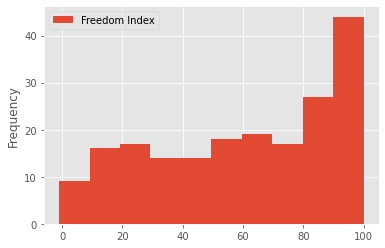

In [10]:
def freedom_index():
    """
    Read data from the Freedom Index.
    """
    # TODO: Add xlrd to requirements.
    xl = pd.ExcelFile(file_path("Freedom_index.xlsx"))
    xl = xl.parse(1)
    xl.set_index("Country")
    return xl

fi = freedom_index().set_index("Country")
fi.columns = ["Freedom Index"]
fi.plot.hist(bins=10)
#print(len(fi))

<font color=red>

### A/B Values

These values are used in the return to skill function. These values are based on each country's income distribution.
</font>

<class 'pandas.core.frame.DataFrame'>
Index: 162 entries, Burundi to Luxembourg
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       162 non-null    float64
 1   B       162 non-null    float64
dtypes: float64(2)
memory usage: 3.8+ KB
                                  A       B
Country                                    
Burundi                      72.993  0.0228
Niger                       113.170  0.0200
Malawi                       58.581  0.0226
Liberia                     144.660  0.0197
Mozambique                   74.334  0.0267
Madagascar                   86.596  0.0252
Sierra Leone                155.360  0.0199
Guinea                      158.650  0.0200
Congo, Dem. Rep.             94.449  0.0256
Central African Republic     43.254  0.0338
Gambia, The                  82.008  0.0283
Togo                        111.860  0.0270
Burkina Faso                205.080  0.0196
Ethiopia                    232.030  0.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f91d94fef10>,
      dtype=object)

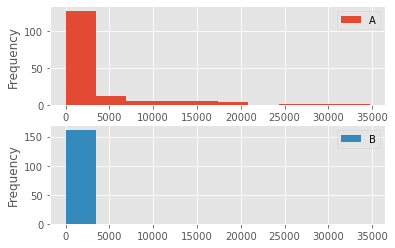

In [11]:
def ab_values():
    """
    Read generated A/B values for each country.
    """
    return pd.read_excel(file_path("A&B values for RTS.xlsx"))

ab = ab_values()
ab = ab.set_index("Country")
#ab.info()
#print(ab)
ab.plot.hist(subplots=True, sharex=False)

<font color=red>
    
### Passport Index

The [Passport Index](https://www.cato.org/human-freedom-index) comes from Arton Capital. 

A low passport index indicates a welcoming country. 
</font>

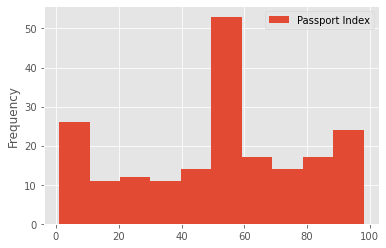

In [12]:
def passport_index():
    """
    Read data from the Passport Index.
    """
    pi = pd.read_excel(file_path("PassportIndex.xlsx"))
    pi = pi.set_index("Country")
    pi.columns = ["Passport Index"]
    return pi

pi = passport_index()
pi.plot.hist()

<font color=red>

## Unemployment

</font>

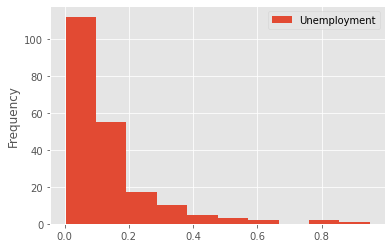

In [13]:
unemployment_data = pd.read_csv(file_path("CIA_Unemployment.csv"), index_col=0, usecols=[1, 2])
unemployment_data["Unemployment"] /= 100
unemployment_data.plot.hist()

<font color=red>

## Population

</font>

In [14]:
# Population
population = pd.read_csv(file_path("newPOP.csv"))
population = population.set_index("Country")
population

,Population
Country,
Aruba,1.016690e+05
Afghanistan,2.880317e+07
Angola,2.336913e+07
Albania,2.913021e+06
Andorra,8.444900e+04
United Arab Emirates,8.270684e+06
Argentina,4.122389e+07
Armenia,2.877311e+06
American Samoa,5.563700e+04


In [15]:
world.update_neighborhoods(ab)
world.update_neighborhoods(pi)
world.update_neighborhoods(unemployment_data)
world.update_neighborhoods(population)
world.update_neighborhoods(fi)

Dropped:  []
Not found in other sets:  ['AND', 'SHN', 'BHR', 'SGS', 'CCK', 'VCT', 'MAC', 'ATA', 'BRN', 'TKL', 'JEY', 'LBY', 'KNA', 'SMR', 'MYT', 'NRU', 'PCN', 'TWN', 'PRI', 'BRB', 'ABW', 'ATF', 'REU', 'AFG', 'NCL', 'ANT', 'MHL', 'GRD', 'PYF', 'CUB', 'GLP', 'QAT', 'COK', 'BHS', 'GGY', 'VIR', 'MCO', 'CYM', 'SAU', 'IMN', 'OMN', 'ARE', 'ERI', 'GUF', 'SOM', 'UMI', 'MLT', 'MSR', 'ASM', 'GUM', 'SJM', 'ZWE', 'PSE', 'KWT', 'SPM', 'WLF', 'FRO', 'HMD', 'PLW', 'ESH', 'BES', 'GRL', 'TCA', 'GNQ', 'CXR', 'SGP', 'HKG', 'KHM', 'PRK', 'MTQ', 'BVT', 'NZL', 'SXM', 'LIE', 'GIB', 'BMU', 'CUW', 'AIA', 'NFK', 'VGB', 'VAT', 'DMA', 'ATG', 'IOT', 'MNP', 'NIU', 'FLK']
Dropped:  ['KHM', 'DMA', 'PLW', 'MAC', 'VCT', 'SGP', 'PSE', 'HKG', 'BHS', 'ZWE', 'KNA', 'BRB', 'ATG', 'GRD', 'AND', 'LIE', 'MLT', 'MCO', 'SMR', 'VAT', 'QAT', 'MHL', 'OMN', 'BHR', 'TWN', 'BRN', 'NZL', 'KWT', 'ARE', 'CUB', 'NRU', 'SAU', 'GNQ', 'ERI', 'LBY', 'AFG', 'PRK', 'SOM']
Not found in other sets:  ['WEGZ']
Dropped:  ['KHM', 'QAT', 'GGY', 'JEY', 

,Freedom Index
ALB,68
ARG,82
ARM,45
AUS,98
AUT,95
AZE,14
BEL,95
BFA,63
BGD,47
BGR,80


<font color=red>

## Shared Language

Agents are assigned proficiency in languages spoken in their origin country. Moving to a country with entirely new languages presents a higher migration cost. 

\begin{equation}
    L_{O\leftrightarrow D}\ = 
    \begin{cases}
        0 & \text{if origin and destination share a spoken language} \\
        1 & \text{otherwise} \\
    \end{cases}
\end{equation}

</font>

In [16]:
lang_csv = pd.read_csv(file_path("languages.csv"), index_col=0)
lang_sets = [set([str(y).strip() for y in x[1] if y is not ' ']) for x in lang_csv.iterrows()]
overlap = []
for s in lang_sets:
    o = []
    for i in range(len(lang_sets)):
        o.append(len(lang_sets[i].intersection(s)) >= 1)
    overlap.append(o)
lang_data = pd.DataFrame(overlap, index=lang_csv.index, columns=lang_csv.index)
print(len(lang_data))
world.add_matrix("language", 1-lang_data)

218
Could not find:  ['ZAR', 'TMP', 'FRE', 'GAZ', 'ROM']
Could not find:  ['ZAR', 'TMP', 'FRE', 'GAZ', 'ROM']


<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-16-71d9554d0afa>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  lang_sets = [set([str(y).strip() for y in x[1] if y is not ' ']) for x in lang_csv.iterrows()]


,ALB,DZA,ARG,ARM,AUS,AUT,AZE,BGD,BLR,BEL,...,UKR,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB
ALB,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DZA,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,0,1
ARG,1,1,0,1,1,1,1,1,1,1,...,1,1,0,0,1,1,0,1,1,1
ARM,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AUS,1,1,1,1,0,1,1,0,1,1,...,1,0,0,1,1,1,1,0,1,1
AUT,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AZE,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BGD,1,1,1,1,0,1,1,0,1,1,...,1,0,0,1,1,1,1,0,1,1
BLR,1,1,1,1,1,1,1,1,0,1,...,0,1,1,1,0,1,1,1,1,1
BEL,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1


<font color=red>

## UN Migration History

</font>

In [17]:
un_pd = pd.read_excel(
        file_path(
            "UN_MigrantStockByOriginAndDestination_2015.xlsx"
        ),
        skiprows=15
    )
un_pd = un_pd.set_index('Unnamed: 1')
un_pd = un_pd.iloc[0:275,7:250]

# TODO: Should we be using the UN numbers for this?
un_pd = un_pd.sort_index().fillna(1)
world.add_matrix("un", un_pd)

Could not find:  ['Africa', 'Asia', 'Australia and New Zealand', 'Caribbean', 'Central America', 'Central Asia', 'Channel Islands', 'Developed regions', 'Developing regions', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'Europe', 'Latin America and the Caribbean', 'Least developed countries', 'Less developed regions excluding least developed countries', 'Melanesia', 'Middle Africa', 'Northern Africa', 'Northern America', 'Northern Europe', 'Oceania', 'Polynesia', 'South America', 'South-Eastern Asia', 'Southern Africa', 'Southern Asia', 'Southern Europe', 'Sub-Saharan Africa', 'WORLD', 'Western Africa', 'Western Asia', 'Western Europe']
Could not find:  ['Channel Islands']


,ALB,DZA,ARG,ARM,AUS,AUT,AZE,BGD,BLR,BEL,...,UKR,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB
ALB,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2628.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DZA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1440.0,1968.0,1.0,1.0,1.0,1.0,1.0,4257.0,1.0
ARG,66.0,104.0,1.0,561.0,275.0,1022.0,1.0,1.0,304.0,537.0,...,4408.0,943.0,5135.0,132749.0,1.0,8.0,1240.0,5.0,1.0,1.0
ARM,1.0,1.0,1.0,1.0,1.0,1.0,87675.0,1.0,328.0,1.0,...,2645.0,1.0,1.0,1.0,1061.0,1.0,1.0,1.0,1.0,1.0
AUS,3334.0,1561.0,15423.0,1371.0,1.0,20434.0,538.0,37092.0,2057.0,7849.0,...,17227.0,1289396.0,110643.0,11140.0,1625.0,1572.0,4895.0,227298.0,675.0,7121.0
AUT,3147.0,1290.0,1523.0,3051.0,2490.0,1.0,1076.0,2737.0,1667.0,2575.0,...,8232.0,11013.0,11054.0,282.0,754.0,7.0,915.0,3344.0,95.0,113.0
AZE,1.0,1.0,1.0,148503.0,1.0,1.0,1.0,1.0,459.0,1.0,...,2817.0,1.0,1.0,1.0,17030.0,1.0,1.0,1.0,1.0,1.0
BGD,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,33470.0,46008.0,1.0,1.0,1.0,1.0,27521.0,1.0,1.0
BLR,1.0,53.0,102.0,5728.0,28.0,59.0,13493.0,1.0,1.0,36.0,...,225734.0,461.0,87.0,28.0,14788.0,1.0,1.0,366.0,33.0,1.0
BEL,7517.0,12054.0,550.0,10433.0,881.0,3020.0,1206.0,2350.0,1675.0,1.0,...,4981.0,27335.0,12853.0,115.0,1521.0,1.0,570.0,1498.0,140.0,123.0


<font color=blue>

# Calculations

</font>

<font color=blue>

## Distance

The great circle distance between the average latitude and longitude of each country is used to determine distance between each pair of countries. A greater distance between countries corresponds to a greater cost of migration.

</font>

In [18]:
distance_frame = pd.read_csv(
    file_path("Country_List_ISO_3166_Codes_Latitude_Longitude.csv"),
    usecols=[2,4,5],
    index_col=0,
    keep_default_na=False)
locations = [(x[1][0], x[1][1]) for x in distance_frame.iterrows()]
rows = []
for i in range(len(locations)):
    row = []
    for loc in locations:
        row.append(haversine(loc, locations[i]))
    rows.append(row)
distance = pd.DataFrame(rows, distance_frame.index, distance_frame.index)
world.add_matrix("distance", distance / distance.max().max())

,ALB,DZA,ARG,ARM,AUS,AUT,AZE,BGD,BLR,BEL,...,UKR,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB
ALB,0.000000,0.105815,0.597475,0.105397,0.689426,0.044053,0.115292,0.332357,0.073126,0.082197,...,0.064645,0.108879,0.457246,0.565456,0.182473,0.789540,0.454184,0.425656,0.197579,0.315345
DZA,0.105815,0.000000,0.492523,0.202478,0.755319,0.116380,0.213293,0.425091,0.172620,0.126921,...,0.169869,0.145872,0.446199,0.459884,0.282619,0.894200,0.376379,0.519595,0.242037,0.279598
ARG,0.597475,0.492523,0.000000,0.691589,0.649479,0.592982,0.702536,0.862511,0.653588,0.576296,...,0.658957,0.571789,0.434729,0.037466,0.770946,0.612930,0.233571,0.888199,0.646693,0.471675
ARM,0.105397,0.202478,0.691589,0.000000,0.586362,0.132565,0.010958,0.227010,0.096682,0.168266,...,0.071601,0.189984,0.525474,0.656711,0.080298,0.692048,0.558385,0.320622,0.139651,0.315251
AUS,0.689426,0.755319,0.649479,0.586362,0.000000,0.718057,0.577700,0.365302,0.667166,0.749560,...,0.650064,0.764047,0.760862,0.663295,0.518109,0.185352,0.854581,0.279761,0.513529,0.524247
AUT,0.044053,0.116380,0.592982,0.132565,0.718057,0.000000,0.140654,0.354319,0.060784,0.039092,...,0.069604,0.065258,0.413926,0.564053,0.201303,0.788136,0.427252,0.444858,0.240108,0.356103
AZE,0.115292,0.213293,0.702536,0.010958,0.577700,0.140654,0.000000,0.217086,0.101034,0.175456,...,0.077016,0.196358,0.528043,0.667619,0.069396,0.681178,0.567306,0.310443,0.141687,0.321286
BGD,0.332357,0.425091,0.862511,0.227010,0.365302,0.354319,0.217086,0.000000,0.301901,0.384278,...,0.285274,0.399565,0.653624,0.827491,0.153111,0.472773,0.779662,0.094504,0.224692,0.390947
BLR,0.073126,0.172620,0.653588,0.096682,0.667166,0.060784,0.101034,0.301901,0.000000,0.082718,...,0.026247,0.098548,0.429499,0.624837,0.149721,0.728063,0.477835,0.389434,0.228628,0.377899
BEL,0.082197,0.126921,0.576296,0.168266,0.749560,0.039092,0.175456,0.384278,0.082718,0.000000,...,0.100071,0.026869,0.375109,0.550318,0.231503,0.792157,0.395708,0.472119,0.279139,0.386979


<font color=blue>

# Editing Variable Values 
Remove the "#" and change the values to best simulate your scenario 

To reset values, run all cells above 

</font>

In [19]:
pd.options.mode.chained_assignment = None  # default='warn'

world.data["Freedom Index"]["AUS"]=50
#world.data["Passport Index"]["AUS"]=80
#world.data["Unemployment"]["AUS"]=.058
#world.data["Population"]["AUS"]=8000000
#world.matrices["un"]["AUS"]["USA"]=77845

<font color=blue>

## Calculate "RTS".
This function measures income potential in a given country based on an agent's skill level (x). 

It takes the form: 
\begin{equation}
Ae^{Bx}
\end{equation}
Where A and B are constants unique to each country 

</font>

In [20]:
world.update_neighborhoods(pd.Series(world.data["A"] * e ** (world.data["B"] * skill.value)), "rts")

Dropped:  []
Not found in other sets:  []


ALB      7315.929956
ARG     27726.158370
ARM      6613.056498
AUS     96290.546610
AUT     80916.261375
AZE      7028.359720
BEL     72140.540141
BFA      1196.792268
BGD      2415.175048
BGR     14903.422355
BIH      9037.792121
BLR      8481.908998
BLZ     11646.248745
BOL      7346.231092
BRA     20465.286555
BTN      5586.967122
BWA     16460.253830
CAF       906.045671
CAN     83284.181912
CHE    146045.602071
CHL     30224.965057
CHN     17346.748040
CMR      2358.536454
COG      3519.491222
COL     13913.532003
COM      1751.861600
CPV      6518.597767
CRI     27031.732177
CYP     32002.966515
CZE     30318.285036
DEU     76963.360034
DJI      4033.327692
DNK     92612.488787
DOM     14708.637191
DZA      6602.028354
ECU     13367.276936
EGY      6194.893421
ESP     54896.372664
EST     34132.774604
ETH      1294.483009
FIN     73422.092309
FJI      9814.341311
FRA     68028.342021
GAB     15057.985546
GBR     76968.523692
GEO      7958.723200
GHA      3242.231105
GRC     36879

<font color=blue>

## Country Beta Values

</font>

In [21]:
world.update_neighborhoods(pd.Series(world.data["A"] * e ** (world.data["B"] * 30)), "beta")

Dropped:  []
Not found in other sets:  []


ALB     2606.619462
ARG     5389.088780
ARM     2140.513925
AUS    27642.934115
AUT    26827.160069
AZE     2316.258927
BEL    26013.513756
BFA      369.222760
BGD      820.182640
BGR     3749.381432
BIH     2641.679555
BLR     3286.869336
BLZ     1560.465434
BOL     1199.839029
BRA     3018.409726
BTN     1431.090278
BWA     1798.492144
CAF      119.234211
CAN    23063.669675
CHE    45874.936212
CHL     5599.449226
CHN     3623.371898
CMR      411.494872
COG      578.287829
COL     2015.489093
COM      318.758663
CPV     1229.563571
CRI     4549.473180
CYP     9410.523667
CZE    12252.757296
DEU    25061.416317
DJI      793.415500
DNK    34206.784468
DOM     2893.407535
DZA     2497.716534
ECU     2417.683138
EGY     2154.859040
ESP    13483.237869
EST     9681.898952
ETH      411.523725
FIN    28281.980643
FJI     2817.485203
FRA    21756.757801
GAB     3359.890726
GBR    22362.748364
GEO     1919.891329
GHA      685.409853
GRC     9334.045220
GTM     1611.386092
HND      825.706252


<font color=blue>


## Freedom Index difference 
\begin{equation}
\frac{FI_D-FI_O}{100}
\end{equation}

This value weighs the origin and destination FI values against eachother. 

</font>

In [22]:
rows=[]
for i in range(len(world.data["Freedom Index"])):
    row = []
    for freedom_index in world.data["Freedom Index"]:
        diff=(freedom_index-(world.data["Freedom Index"][i]))/100.0
        row.append(diff)
    rows.append(row)
fi_diff = (pd.DataFrame(rows, world.data["Freedom Index"].index, world.data["Freedom Index"].index))
print(fi_diff)

      ALB   ARG   ARM   AUS   AUT   AZE   BEL   BFA   BGD   BGR  ...   UKR  \
ALB  0.00  0.14 -0.23 -0.18  0.27 -0.54  0.27 -0.05 -0.21  0.12  ... -0.07   
ARG -0.14  0.00 -0.37 -0.32  0.13 -0.68  0.13 -0.19 -0.35 -0.02  ... -0.21   
ARM  0.23  0.37  0.00  0.05  0.50 -0.31  0.50  0.18  0.02  0.35  ...  0.16   
AUS  0.18  0.32 -0.05  0.00  0.45 -0.36  0.45  0.13 -0.03  0.30  ...  0.11   
AUT -0.27 -0.13 -0.50 -0.45  0.00 -0.81  0.00 -0.32 -0.48 -0.15  ... -0.34   
AZE  0.54  0.68  0.31  0.36  0.81  0.00  0.81  0.49  0.33  0.66  ...  0.47   
BEL -0.27 -0.13 -0.50 -0.45  0.00 -0.81  0.00 -0.32 -0.48 -0.15  ... -0.34   
BFA  0.05  0.19 -0.18 -0.13  0.32 -0.49  0.32  0.00 -0.16  0.17  ... -0.02   
BGD  0.21  0.35 -0.02  0.03  0.48 -0.33  0.48  0.16  0.00  0.33  ...  0.14   
BGR -0.12  0.02 -0.35 -0.30  0.15 -0.66  0.15 -0.17 -0.33  0.00  ... -0.19   
BIH  0.13  0.27 -0.10 -0.05  0.40 -0.41  0.40  0.08 -0.08  0.25  ...  0.06   
BLR  0.48  0.62  0.25  0.30  0.75 -0.06  0.75  0.43  0.27  0.60 

<font color=blue>


## Political Barriers
$$  PB = \delta_1 \frac{PIR_{D}}{100} +  \delta_2 (1-\frac{(FI_D-FI_O)}{100}) $$

Political barriers combines passport index rank (PIR) and freedom index scores (FI) for each country. The greater the value, the higher the cost of migration. 

<font color=blue>


In [23]:
delta1=.5
delta2=.25
political_barriers=delta1*world.data["Passport Index"]/100.0 + delta2*(1 - fi_diff)
print(political_barriers)


        ALB     ARG     ARM     AUS     AUT     AZE     BEL     BFA     BGD  \
ALB  0.5350  0.4900  0.4425  0.6950  0.4325  0.7950  0.4325  0.5875  0.3775   
ARG  0.5700  0.5250  0.4775  0.7300  0.4675  0.8300  0.4675  0.6225  0.4125   
ARM  0.4775  0.4325  0.3850  0.6375  0.3750  0.7375  0.3750  0.5300  0.3200   
AUS  0.4900  0.4450  0.3975  0.6500  0.3875  0.7500  0.3875  0.5425  0.3325   
AUT  0.6025  0.5575  0.5100  0.7625  0.5000  0.8625  0.5000  0.6550  0.4450   
AZE  0.4000  0.3550  0.3075  0.5600  0.2975  0.6600  0.2975  0.4525  0.2425   
BEL  0.6025  0.5575  0.5100  0.7625  0.5000  0.8625  0.5000  0.6550  0.4450   
BFA  0.5225  0.4775  0.4300  0.6825  0.4200  0.7825  0.4200  0.5750  0.3650   
BGD  0.4825  0.4375  0.3900  0.6425  0.3800  0.7425  0.3800  0.5350  0.3250   
BGR  0.5650  0.5200  0.4725  0.7250  0.4625  0.8250  0.4625  0.6175  0.4075   
BIH  0.5025  0.4575  0.4100  0.6625  0.4000  0.7625  0.4000  0.5550  0.3450   
BLR  0.4150  0.3700  0.3225  0.5750  0.3125  0.6750 

In [24]:
world.add_matrix("Political Barriers", political_barriers)

,ALB,ARG,ARM,AUS,AUT,AZE,BEL,BFA,BGD,BGR,...,UKR,URY,USA,UZB,VEN,VNM,VUT,YEM,ZAF,ZMB
ALB,0.5350,0.4900,0.4425,0.6950,0.4325,0.7950,0.4325,0.5875,0.3775,0.4700,...,0.4975,0.4650,0.5825,0.8625,0.6600,0.7750,0.3800,0.8300,0.5250,0.4100
ARG,0.5700,0.5250,0.4775,0.7300,0.4675,0.8300,0.4675,0.6225,0.4125,0.5050,...,0.5325,0.5000,0.6175,0.8975,0.6950,0.8100,0.4150,0.8650,0.5600,0.4450
ARM,0.4775,0.4325,0.3850,0.6375,0.3750,0.7375,0.3750,0.5300,0.3200,0.4125,...,0.4400,0.4075,0.5250,0.8050,0.6025,0.7175,0.3225,0.7725,0.4675,0.3525
AUS,0.4900,0.4450,0.3975,0.6500,0.3875,0.7500,0.3875,0.5425,0.3325,0.4250,...,0.4525,0.4200,0.5375,0.8175,0.6150,0.7300,0.3350,0.7850,0.4800,0.3650
AUT,0.6025,0.5575,0.5100,0.7625,0.5000,0.8625,0.5000,0.6550,0.4450,0.5375,...,0.5650,0.5325,0.6500,0.9300,0.7275,0.8425,0.4475,0.8975,0.5925,0.4775
AZE,0.4000,0.3550,0.3075,0.5600,0.2975,0.6600,0.2975,0.4525,0.2425,0.3350,...,0.3625,0.3300,0.4475,0.7275,0.5250,0.6400,0.2450,0.6950,0.3900,0.2750
BEL,0.6025,0.5575,0.5100,0.7625,0.5000,0.8625,0.5000,0.6550,0.4450,0.5375,...,0.5650,0.5325,0.6500,0.9300,0.7275,0.8425,0.4475,0.8975,0.5925,0.4775
BFA,0.5225,0.4775,0.4300,0.6825,0.4200,0.7825,0.4200,0.5750,0.3650,0.4575,...,0.4850,0.4525,0.5700,0.8500,0.6475,0.7625,0.3675,0.8175,0.5125,0.3975
BGD,0.4825,0.4375,0.3900,0.6425,0.3800,0.7425,0.3800,0.5350,0.3250,0.4175,...,0.4450,0.4125,0.5300,0.8100,0.6075,0.7225,0.3275,0.7775,0.4725,0.3575
BGR,0.5650,0.5200,0.4725,0.7250,0.4625,0.8250,0.4625,0.6175,0.4075,0.5000,...,0.5275,0.4950,0.6125,0.8925,0.6900,0.8050,0.4100,0.8600,0.5550,0.4400


<font color=blue>


## Migration History 
Out Migration:  
\begin{equation} OM_{O\rightarrow D}\ = \frac {\text {migrants from origin in destination}} {\text {population of origin}} \end{equation}

Ethnic Enclave: 
\begin{equation} EE_{O\leftrightarrow D}\ = \frac {\text{migrants from origin in destination}} {\text {population of destination.}} \end{equation}

Migration History:
\begin{equation}
MH_{O\rightarrow D}\ = \gamma_1 (1-OM_{O\rightarrow D})\ + \gamma_2 (1-EE_{O\rightarrow D}) 
\end{equation}

</font>

In [25]:
gamma1=.5
gamma2=.5
OM=world.matrices['un'].sort_index(axis=1).sort_index(axis=0)/world.data['Population']
#transpose UN matrix for this calculation so that we are dividing by population of destination 
EE=world.matrices['un'].T.sort_index(axis=1).sort_index(axis=0)/world.data['Population']
EE=EE.T
MH=gamma1*(OM)+gamma2*(EE)
#print(MH)
max_MH = MH.max().nlargest(10).mean()
#print(max_MH)
MH = 1 - (MH/max_MH)
MH[MH<0] = 0
print(MH)

          ALB       ARG       ARM       AUS       AUT       AZE       BEL  \
ALB  0.999997  0.999998  0.999997  0.999998  0.999998  0.999998  0.999998   
ARG  0.999887  1.000000  0.999026  0.999911  0.999314  0.999999  0.999709   
ARM  0.999997  0.999998  0.999997  0.999998  0.999998  0.812485  0.999998   
AUS  0.993949  0.994984  0.997484  1.000000  0.984259  0.999608  0.994972   
AUT  0.993198  0.998977  0.993345  0.998082  0.999999  0.998844  0.997459   
AZE  0.999998  0.999999  0.682388  0.999999  0.999999  0.999999  0.999999   
BEL  0.984728  0.999702  0.978596  0.999436  0.997019  0.998861  0.999999   
BFA  0.999998  1.000000  0.999998  0.999999  0.999999  0.999999  0.999999   
BGD  0.999998  1.000000  0.999998  1.000000  0.999999  0.999999  1.000000   
BGR  0.997466  0.999911  0.996627  0.999833  0.999382  0.997742  0.998875   
BIH  0.999997  0.999999  0.999997  0.999999  0.999657  0.999998  0.999998   
BLR  0.999998  0.999938  0.987885  0.999980  0.999938  0.986402  0.999967   

In [26]:
world.add_matrix("Migration History", MH)

,ALB,ARG,ARM,AUS,AUT,AZE,BEL,BFA,BGD,BGR,...,UKR,URY,USA,UZB,VEN,VNM,VUT,YEM,ZAF,ZMB
ALB,0.999997,0.999998,0.999997,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,...,0.999998,0.999997,0.995747,0.999998,0.999998,0.999998,0.999979,0.999998,0.999998,0.999998
ARG,0.999887,1.000000,0.999026,0.999911,0.999314,0.999999,0.999709,0.999995,1.000000,0.999780,...,0.999052,0.801250,0.999341,1.000000,0.999660,0.999999,0.999841,1.000000,0.999974,1.000000
ARM,0.999997,0.999998,0.999997,0.999998,0.999998,0.812485,0.999998,0.999998,0.999998,0.999998,...,0.995438,0.999997,0.999998,0.998105,0.999998,0.999998,0.999979,0.999998,0.999998,0.999998
AUS,0.993949,0.994984,0.997484,1.000000,0.984259,0.999608,0.994972,0.999989,0.991000,0.996637,...,0.994595,0.982222,0.974878,0.999390,0.998175,0.939612,0.968600,0.999723,0.944336,0.996090
AUT,0.993198,0.998977,0.993345,0.998082,0.999999,0.998844,0.997459,0.999896,0.998388,0.981281,...,0.994565,0.999452,0.993661,0.999456,0.999342,0.997953,0.999858,0.999928,0.998185,0.999899
AZE,0.999998,0.999999,0.682388,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,...,0.998260,0.999998,0.999999,0.988432,0.999999,0.999999,0.999980,0.999999,0.999999,0.999999
BEL,0.984728,0.999702,0.978596,0.999436,0.997019,0.998861,0.999999,0.999325,0.998921,0.971999,...,0.997358,0.999792,0.994297,0.999099,0.999664,0.999277,0.999980,0.999912,0.999542,0.999906
BFA,0.999998,1.000000,0.999998,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,0.999999,...,1.000000,0.999998,1.000000,1.000000,1.000000,1.000000,0.999980,1.000000,1.000000,0.999999
BGD,0.999998,1.000000,0.999998,1.000000,0.999999,0.999999,1.000000,1.000000,1.000000,0.999999,...,1.000000,0.999999,0.997893,1.000000,1.000000,0.997677,0.999980,1.000000,1.000000,1.000000
BGR,0.997466,0.999911,0.996627,0.999833,0.999382,0.997742,0.998875,0.999988,0.999619,0.999999,...,0.995307,0.999968,0.998624,0.999401,0.999974,0.999570,0.999674,0.999959,0.999874,0.999989


<font color=blue>


# Cost

</font>


<font color=blue>


The cost of migration between an origin and destination is the weighted average of the distance, migration history, shared language and political barriers between the two countries. 
\begin{equation}
C = { \alpha_1 \frac{D_{O\leftrightarrow D}} {D_{Max}} + \alpha_2 MH_{O\rightarrow D}  + \alpha_3 L_{O\leftrightarrow D} + \alpha_4 PB}
\end{equation}

</font>

In [27]:
# Cost
alpha1=.35
alpha2=.35
alpha3=.15
alpha4=.15
c = (alpha1*world.matrices["distance"] +
     alpha2*world.matrices["Migration History"] +
     alpha3*world.matrices["language"] +
     alpha4*world.matrices["Political Barriers"])
world.add_matrix("cost", c * world.data['beta'])

,ALB,ARG,ARM,AUS,AUT,AZE,BEL,BFA,BGD,BGR,...,UKR,URY,USA,UZB,VEN,VNM,VUT,YEM,ZAF,ZMB
ALB,1121.495098,4217.584483,1291.292653,23373.444798,15567.607949,1527.807999,15442.743884,241.531867,551.941501,2169.775835,...,837.110850,5254.495086,19528.139411,810.441143,3218.327424,920.509002,1247.887196,370.917682,881.756809,223.960150
ARG,2071.158480,2310.571387,1740.965756,23131.234619,20856.194164,2016.042204,20075.328687,273.160722,708.435962,2973.230605,...,1135.552541,2522.667339,15565.210705,1057.365904,2275.359899,1121.565513,1163.113382,457.779732,894.598524,243.949143
ARM,1586.161586,4348.619484,872.792121,22137.876153,16167.311108,1271.232164,16002.013994,249.274366,514.625940,2217.772874,...,826.196866,5414.077492,19966.464534,757.776096,3336.559636,865.912310,1183.874724,355.463936,874.980339,221.074194
AUS,2118.350794,4269.840553,1635.291227,12370.208915,21567.306210,1886.727254,21297.556148,312.097983,430.251886,2989.475632,...,1112.183802,5400.102024,18015.244358,939.633857,3781.989986,645.102370,904.670103,426.388791,716.777609,245.626511
AUT,1572.867580,4261.748279,1328.335575,23911.786774,11401.532544,1570.885293,15290.552365,247.188599,566.087836,2220.103162,...,851.069345,5319.133078,19377.158588,829.760576,3220.319718,939.912041,1262.250008,384.278253,909.856936,232.078819
AZE,1564.888057,4306.621508,939.249462,21732.730540,15931.402587,1039.999422,15765.083619,246.394691,502.242989,2186.445080,...,813.944176,5360.641582,19685.668008,735.767098,3300.458150,847.643094,1160.770429,349.629056,863.360056,217.903343
BEL,1599.939233,4231.644263,1344.032038,24229.679803,15764.683808,1599.112952,11055.735542,192.803886,574.841047,2258.800132,...,867.385705,5287.041053,19027.313096,841.972001,3173.920021,951.946954,1264.421328,391.580249,922.024740,235.681962
BFA,1679.739455,3869.784919,1413.023276,23946.722385,17015.653796,1660.371833,12673.124957,161.073352,593.002948,2408.794331,...,927.032219,4805.812613,19700.835743,877.863257,3055.382962,980.302431,1323.176503,383.319672,828.704517,213.944836
BGD,1795.177532,4675.055589,1365.546971,15873.420543,18269.601179,1592.092292,17988.271130,276.368142,327.047810,2517.477313,...,934.306412,5828.350878,17214.065987,789.221293,3668.587982,590.198575,1070.073976,371.781190,717.191325,230.155713
BGR,1543.291387,4285.878579,1282.861447,23315.261109,15753.197634,1519.137930,15623.788081,246.067482,549.362446,1593.485451,...,830.433403,5341.248765,19729.432569,806.241102,3266.521835,916.495229,1242.186194,371.928873,891.826968,226.379170


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

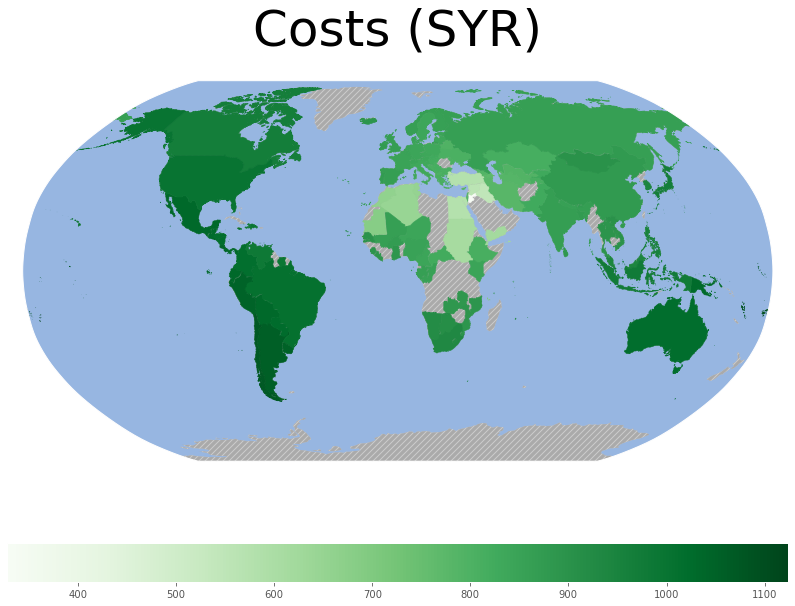

In [28]:
map_plot(world.matrices["cost"]["SYR"], title="Costs (SYR)")

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

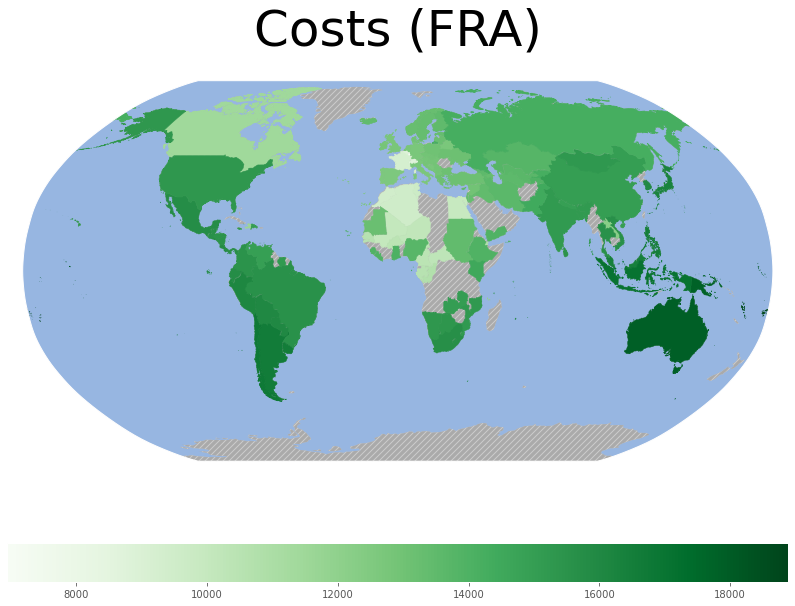

In [29]:
map_plot(world.matrices["cost"]["FRA"], title="Costs (FRA)")

In [30]:
world.update_neighborhoods((1 - world.data["Unemployment"]) * world.data["rts"], "wages")

Dropped:  []
Not found in other sets:  []


ALB      6050.274073
ARG     25508.065701
ARM      5416.093272
AUS     90705.694907
AUT     75980.369431
AZE      6578.544698
BEL     66080.734769
BFA       275.262222
BGD      2296.831470
BGR     13577.017766
BIH      5133.465925
BLR      8422.535635
BLZ     10143.882657
BOL      6795.263760
BRA     17886.660449
BTN      5441.705977
BWA     13168.203064
CAF       833.562018
CAN     77371.004996
CHE    141080.051601
CHL     28109.217503
CHN     16618.184622
CMR      1650.975518
COG      1654.160874
COL     12591.746463
COM      1637.990596
CPV      5736.366035
CRI     24517.781084
CYP     28226.616466
CZE     28620.461074
DEU     73653.935553
DJI      1613.331077
DNK     88722.764258
DOM     12678.845259
DZA      5783.376838
ECU     12632.076704
EGY      5383.362383
ESP     44081.787249
EST     31914.144255
ETH      1067.948483
FIN     66740.681909
FJI      8950.679276
FRA     61429.592845
GAB     11895.808581
GBR     73043.128984
GEO      6995.717692
GHA      3073.635088
GRC     27807

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

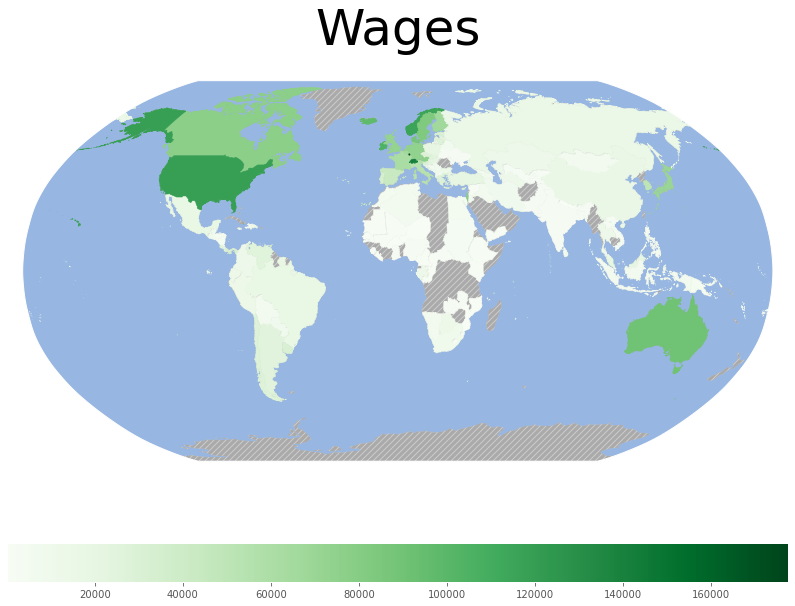

In [31]:
map_plot(world.data["wages"], title="Wages")

In [32]:
#beta = world.data.rts.mean()
#beta = RTS_list.median()

world.add_matrix("migration", (pd.DataFrame(
    np.array(
        [[x] * len(world.data) for x in world.data["wages"].values]
    ) - np.array(
        [list(world.data["wages"].values)] * len(world.data)
    ),
    world.data.index,
    world.data.index
    )  - world.matrices["cost"]).clip(lower=0))
world.matrices["migration"] = world.matrices["migration"] / (world.matrices["migration"].sum() + 1)
world.matrices["migration"] = world.matrices["migration"] / world.matrices["migration"].sum(axis=1).max()

# TODO: Why does this require being transposed?
world.matrices["migration"] = (0.15 * world.matrices["migration"].transpose() * world.data["Population"]).transpose()

world.matrices["migration"]

,ALB,ARG,ARM,AUS,AUT,AZE,BEL,BFA,BGD,BGR,...,UKR,URY,USA,UZB,VEN,VNM,VUT,YEM,ZAF,ZMB
ALB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.943756,26.072257,0.000000,...,18.145757,0.000000,0.000000,12.361000,0.000000,9.459488,0.000000,33.474201,0.000000,26.864099
ARG,2396.838907,0.000000,2455.021974,0.000000,0.000000,2368.034352,0.000000,2613.563414,2593.384114,1567.266754,...,2567.645803,0.000000,0.000000,2552.721618,0.000000,2542.372502,2505.081174,2614.409520,2221.444927,2612.848914
ARM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.750294,20.951503,0.000000,...,12.676402,0.000000,0.000000,7.185737,0.000000,4.283890,0.000000,28.291397,0.000000,21.473628
AUS,6080.964077,8118.750671,5981.138359,0.000000,0.000000,6153.758163,1939.034918,5043.219487,5418.854099,6932.480524,...,5576.416585,8313.264554,0.000000,5684.865304,8033.762737,5748.694470,5999.837561,5249.773565,6459.028949,5398.623823
AUT,1911.797603,2337.486216,1879.148939,0.000000,0.000000,1926.712890,0.000000,1603.000341,1709.564429,2136.242058,...,1762.913437,2310.304604,0.000000,1791.007648,2339.782281,1801.114144,1869.870944,1663.650170,1995.223997,1706.525096
AZE,0.000000,0.000000,6.558446,0.000000,0.000000,0.000000,0.000000,139.300174,95.668443,0.000000,...,71.009297,0.000000,0.000000,54.812053,0.000000,45.915986,0.000000,117.384533,0.000000,96.979861
BEL,2128.946512,2394.818236,2097.503662,0.000000,0.000000,2142.685012,0.000000,1815.866899,1925.357139,2323.456168,...,1980.567087,2267.624016,0.000000,2009.017232,2404.825231,2018.783734,2087.314512,1877.987637,2204.042601,1922.560744
BFA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BGD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,674.466820,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217.100356,0.000000,0.000000
BGR,147.978828,0.000000,165.076799,0.000000,0.000000,137.628163,0.000000,245.255546,221.864481,0.000000,...,209.076408,0.000000,0.000000,198.607126,0.000000,192.993003,162.333789,234.187615,75.645377,223.252518


In [33]:
#map_plot(
#    world.matrices["migration"].sum(axis=1)+1,
#    title="Immigration Estimations (x={})".format(skill.value),
#    normc=matplotlib.colors.LogNorm
#)

In [34]:
#map_plot(
#    world.matrices["migration"].sum(),
#    title="Estimated Number of Emigrants (x={})".format(skill.value),
#    normc=matplotlib.colors.Normalize
#)

In [35]:
#map_plot(
#    world.matrices["migration"].sum(axis=1) - world.matrices["migration"].sum(),
#    title="Net Migration (x={})".format(skill.value),
#    normc=gos.visualization.MidPointNorm
#)

<font color=purple>


# Exporting Data

</font>

<font color=purple>

Defining Vectors

</font>

In [36]:
immigration = world.matrices["migration"].sum(axis=1)+1
emigration = world.matrices["migration"].sum()
net_migration = world.matrices["migration"].sum(axis=1) - world.matrices["migration"].sum()

<font color=purple>


- To export the following data, remove the "#" and run the cell. 
- The excel files will appear in the data folder under multiscale-migration. 
- Change the file names (in red) everytime you want to create a spreadsheet with new results. Otherwise new changes will override the original spreadsheets. 

</font>

In [37]:
%cd ~/Public/GOS/examples/multiscale-migration/data
immigration.to_excel("immigration.xlsx")
emigration.to_excel("emigration.xlsx")
net_migration.to_excel("net_migration.xlsx")

[Errno 2] No such file or directory: '/afs/crc.nd.edu/user/p/pbrenne1/Public/GOS/examples/multiscale-migration/data'
/afs/crc.nd.edu/user/p/pbrenne1/Research/migration/GOS_new/examples/multiscale-migration
